# depth losses analysis script

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from datetime import datetime

from oceantracker.post_processing.read_output_files import load_output_files 
from oceantracker.util.polygon_util import InsidePolygon
# from oceantracker.post_processing.plotting import plot_statistics
# from oceantracker.post_processing.plotting import stats_plot 


In [2]:
path_to_dir = '/scratch/local1/output/22_11_01_depth_losses_v11'
cases = load_output_files.get_case_info_files_from_dir(path_to_dir)


[0]


In [3]:
!du path_to_dir

du: cannot access 'path_to_dir': No such file or directory


In [4]:
# observational polygons in which to calculate concentrations
observational_polygone = [
    {
        'name': 'pre-splitting',
        'points': np.array([
           [572085,5922830],
           [572169,5922719],
           [572246,5922848],
           [572162,5922948] 
        ])
    },
    # norderelbe
    ## low-depth
    {
        'name': 'norder-bunthaus',
        'points': np.array([
            [570470,5925498],
            [570537,5925521],
            [570508,5925681],
            [570433,5925668]
        ])
    },
    {
        'name': 'norder-kaltehofe',
        'points': np.array([
            [569021,5931319],
            [569084,5931274],
            [569139,5931362],
            [569077,5931410]
        ])
    },
    ## medium-depth
    {
        'name': 'norder-elphi',
        'points': np.array([
            [565158,5932675],
            [565229,5932795],
            [565151,5932838],
            [565069,5932716]
        ])
    },
    ## high-depth
    {
        'name': 'norder-dockland',
        'points': np.array([
            [562387,5933002],
            [562390,5932860],
            [562513,5932872],
            [562507,5933012]
        ])
    },
    # suederelbe
    ## low-depth
    {
        'name': 'sueder-bunthaus',
        'points': np.array([
            [570405,5923818],
            [570454,5923894],
            [570397,5923946],
            [570345,5923871]
        ])
    },
    {
        'name': 'sueder-europabruecke',
        'points': np.array([
            [565993,5925470], # 0 
            [565977,5925374],  # 3
            [566083,5925340], # 2
            [566099,5925433] # 1
            
            
        ])
    },
    ## medium depth
    {
        'name': 'sueder-nynas',
        'points': np.array([
            [563601,5926690],
            [563675,5926768],
            [563630,5926837],
            [563552,5926761]
        ])
    },
    ## high depth
    {
        'name': 'sueder-kohlbrandt',
        'points': np.array([
            [562176,5931052],
            [562290,5931042],
            [562293,5931190],
            [562180,5931192]
        ])
    },
    # post sueder-norder unification
    {
        'name': 'post-unification',
        'points': np.array([
            [560484,5932946],
            [560485,5932765],
            [560640,5932764],
            [560637,5932946]
        ])
    }
]

###  Creating the polygon stats based on the tracks

In [5]:
# for each obs poly create a InsidePolygon object
# with this object we extract the triangles of the grid which are part of the polygon
# with the subsets of triangles we can calculate the concentration in the polygon (and reduce data size)

# load grid
grid = load_output_files.load_grid(cases[0])

# create InsidePolygon objects
for poly in observational_polygone:
    poly['InsidePolygon'] = InsidePolygon(poly['points'])

# get triangles of grid which are part of the polygon

# get triangles of grid
triangles = grid['triangles']
# nodes of triangles
x = grid['x']

for poly in observational_polygone:
    # print(poly['name'])
    poly['triangles'] = []

    for ii,tri in enumerate(triangles):
        # if ii%10000 == 0: print(ii)
        nodes = x[tri]
        # check if triangle is part of polygon

        if poly['InsidePolygon'].is_inside(nodes).any():
            poly['triangles'].append(ii)

    poly['triangles'] = np.array(poly['triangles'])
    # print(poly['triangles'])
        

## concentrations

In [17]:
# load concentration field
c_top = load_output_files.load_concentration_vars(
            cases[0], var_list=['particle_concentration'],name='top_layer')

c_full = load_output_files.load_concentration_vars(
            cases[0], var_list=['particle_concentration'],name='full_coloumn')


### post process polygon based data

In [18]:
for poly in observational_polygone:
    if len(poly['triangles']) > 0:
        poly['concentration'] = np.average(c_top['particle_concentration'][:,poly['triangles']],axis=1)
    else:
        poly['concentration'] = np.full(c_top['particle_concentration'].shape[0],np.nan)

# create a pandas df with concentration data
import pandas as pd

df = pd.DataFrame()
for poly in observational_polygone:
    df[poly['name']] = poly['concentration']
df['time'] = c_top['time']

# transform time from posix to datetime
df['time'] = pd.to_datetime(df['time'],unit='s')



### plot concentrations per poly

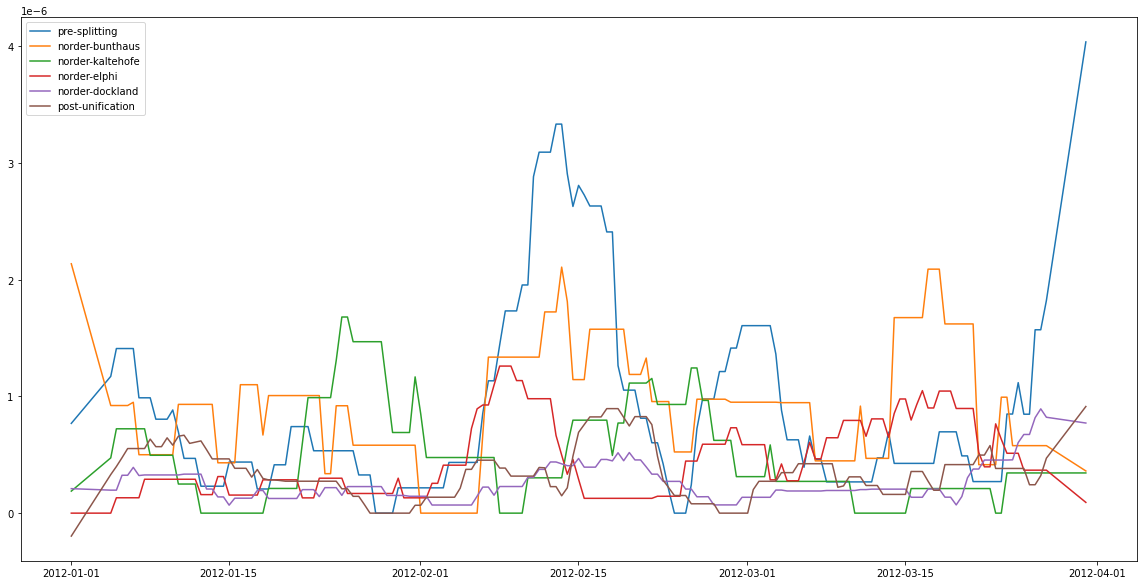

In [23]:
# same as above with a low pass filter (savitzky golay)
from scipy.signal import savgol_filter

filter_window = 15

plt.figure(figsize=(20,10))
plt.plot(df['time'],savgol_filter(df['pre-splitting'],filter_window,1),label='pre-splitting')

# plot all polies with norder in name
for keys in df.keys():
    if 'norder' in keys:
        plt.plot(df['time'],savgol_filter(df[keys],filter_window,1),label=keys)

plt.plot(df['time'],savgol_filter(df['post-unification'],filter_window,1),label='post-unification')
plt.legend()


/tmp/ipykernel_16137/3126582658.py:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(df['time'],savgol_filter(df['post-unification'],filter_window,1)/savgol_filter(df['pre-splitting'],filter_window,1),label='post/pre')
/tmp/ipykernel_16137/3126582658.py:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(df['time'],savgol_filter(df['post-unification'],filter_window,1)/savgol_filter(df['pre-splitting'],filter_window,1),label='post/pre')


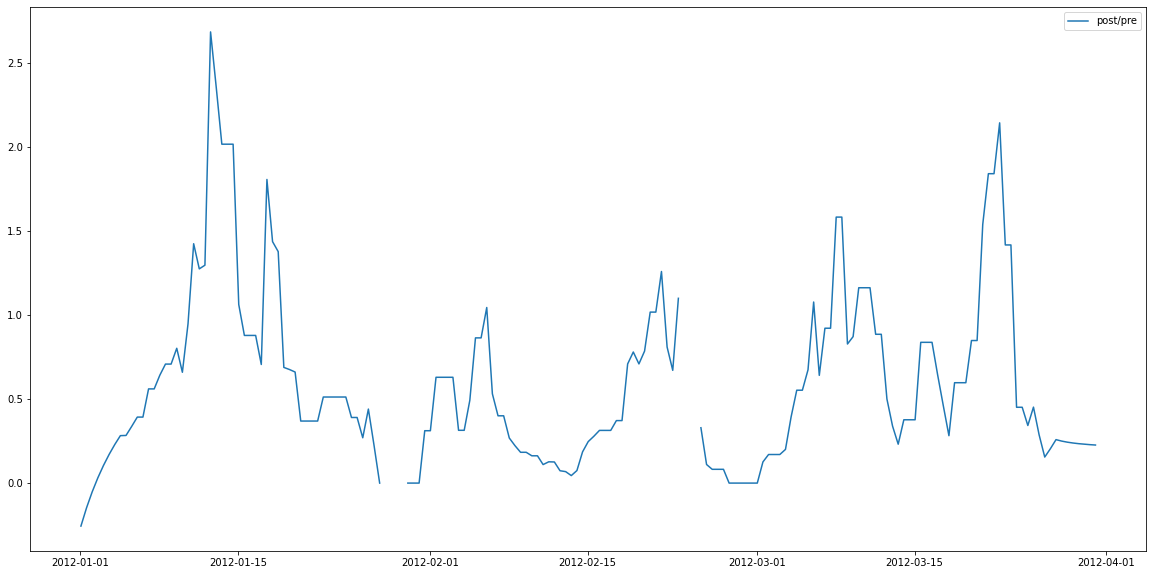

In [24]:
# plot post relative to pre
plt.figure(figsize=(20,10))

plt.plot(df['time'],savgol_filter(df['post-unification'],filter_window,1)/savgol_filter(df['pre-splitting'],filter_window,1),label='post/pre')

plt.legend()


## Does the salinity cut off cause the loss of particles in between pre and post harbor?

In [10]:
### load salinity data

In [27]:
from netCDF4 import Dataset

# temp open file
data =  Dataset('/scratch/local1/hzg2/schout_11.nc')
salt = data.variables['salt'][:].filled(np.nan)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
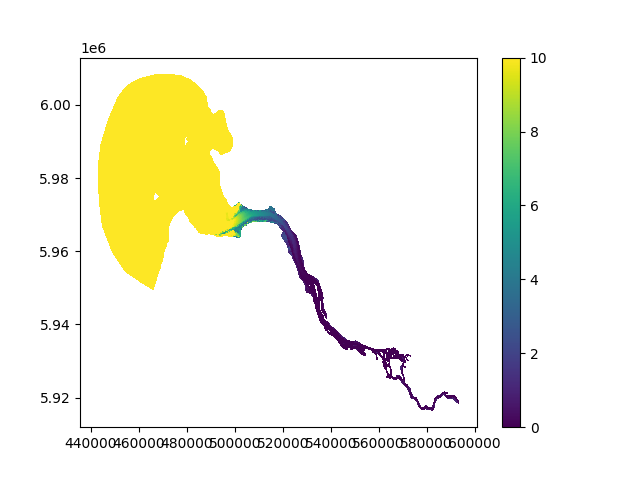

In [7]:
%matplotlib widget
plt.tripcolor(grid['x'][:,0],grid['x'][:,1],grid['triangles'],np.max(np.max(salt[:,:,:],axis=2),axis=0),shading='flat')
# set color range from 0 to 1
plt.clim(0,10)
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
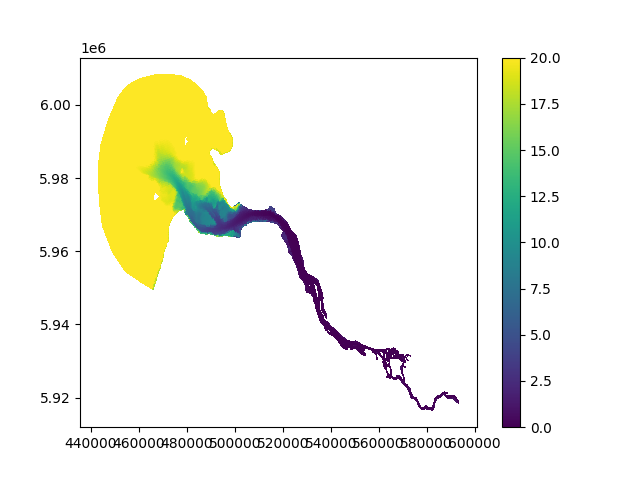

In [24]:
%matplotlib widget
plt.tripcolor(grid['x'][:,0],grid['x'][:,1],grid['triangles'],np.min(np.min(salt[:,:,:],axis=2),axis=0),shading='flat')
# set color range from 0 to 1
plt.clim(0,20)

plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
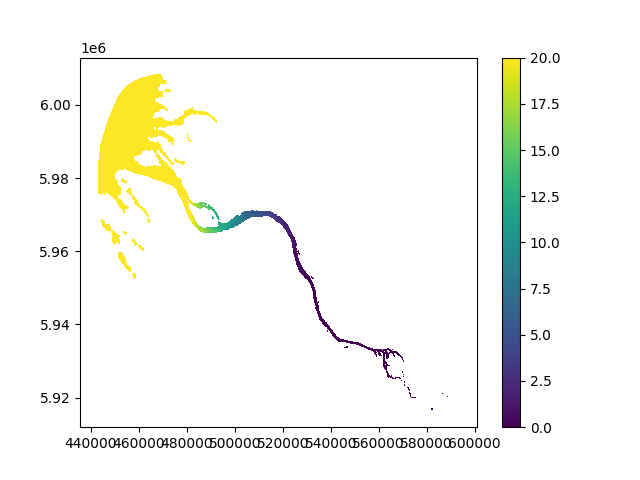

In [28]:
%matplotlib widget
plt.tripcolor(grid['x'][:,0],grid['x'][:,1],grid['triangles'],np.max(np.max(salt[:,:,:],axis=2),axis=0),shading='flat')
# set color range from 0 to 1
plt.clim(0,20)

plt.colorbar()

### comment

There are "high salinity" areas before the we enter the max turbidity zones. especially some shores with >1PSU values
Rerun the model with a 10PSU cut-off to make sure that this does not cause the issue (hopefully)

## Looking at vertical distribution

Are there i.e. aggregations on the top or bottom of the water column that might cause the loss in tracers

In [7]:
# tracks
tracks = load_output_files.load_track_data(cases[0], var_list=['tide','water_depth'])

In [8]:
tracks['time'][1] - tracks['time'][0]

43200.0

In [9]:
observational_polygone[-1]['InsidePolygon'].is_inside(x)

array([False, False, False, ..., False, False, False])

In [10]:
sliced_tracks = tracks['x'][np.where(tracks['status'] > 0)]
sliced_tracks = sliced_tracks[:,:]

In [11]:
sliced_tracks = sliced_tracks[observational_polygone[-1]['InsidePolygon'].is_inside(sliced_tracks)]

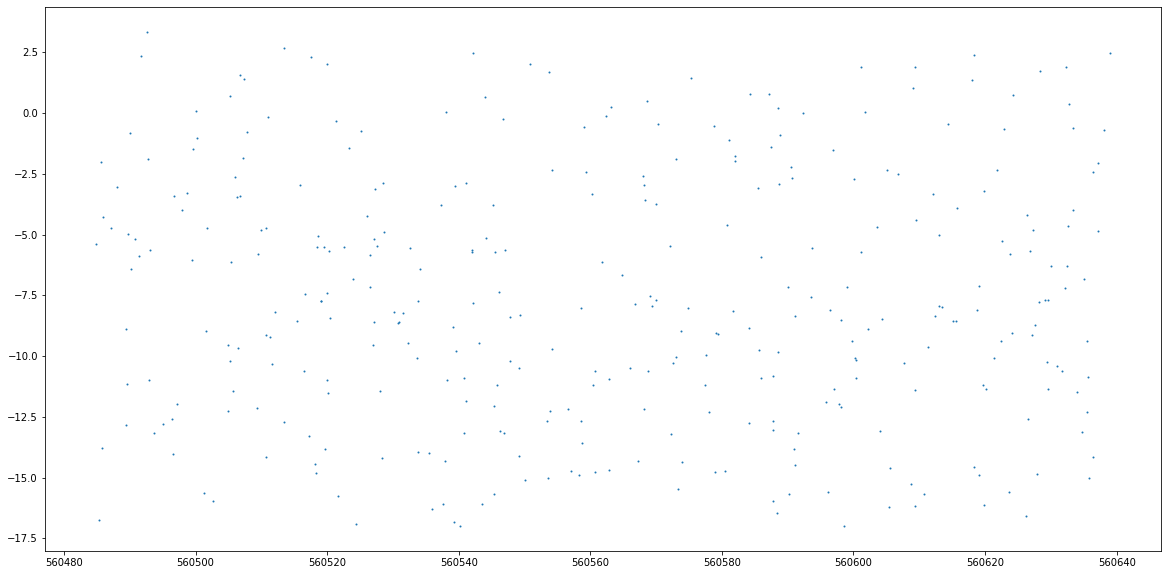

In [12]:
plt.figure(figsize=(20,10))
plt.scatter(sliced_tracks[:,0],sliced_tracks[:,2],s=1)

In [13]:
from copy import deepcopy

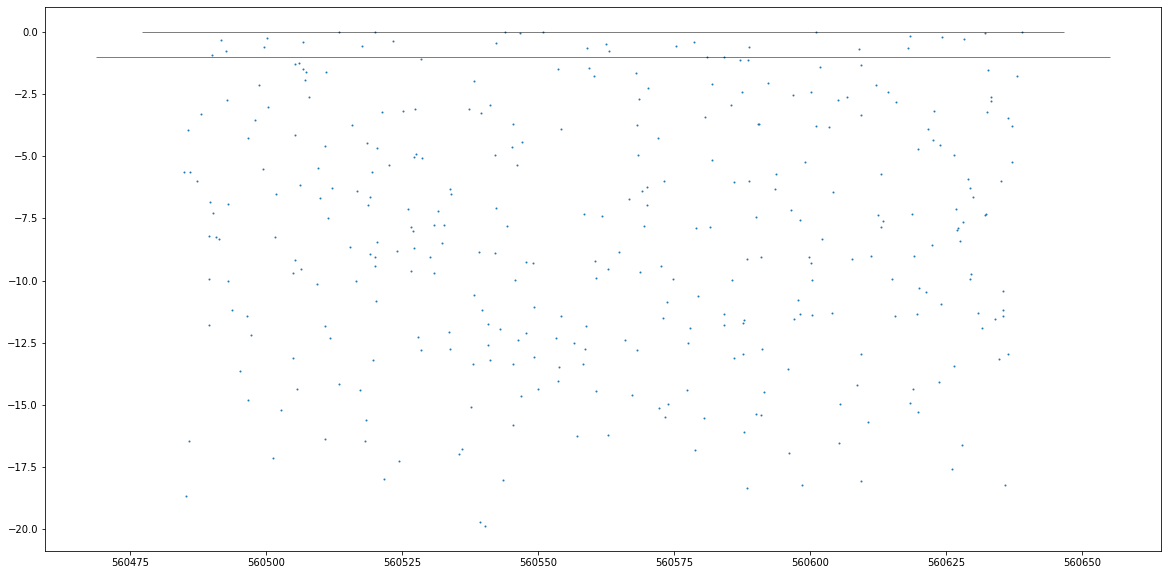

In [14]:
# rescale depth to relative from surface to bottom
x = tracks['x'][np.where(tracks['status'] > 0)]
inside = deepcopy(observational_polygone[-1]['InsidePolygon'].is_inside(x))
x = x[inside]
z = x[:,2]

bottom = tracks['water_depth']
bottom = bottom[np.where(tracks['status'] > 0)]
bottom = bottom[inside]

surface = tracks['tide']
surface = surface[np.where(tracks['status'] > 0)]
surface = surface[inside]

# calc distance from surface
distance_from_surface = z - surface

plt.figure(figsize=(20,10))
plt.scatter(x[:,0],distance_from_surface,s=1)
plt.hlines(0,plt.xlim()[0],plt.xlim()[1],color='k',linewidth=0.5)
plt.hlines(-1,plt.xlim()[0],plt.xlim()[1],color='k',linewidth=0.5)

(array([ 9., 15., 28., 33., 41., 45., 50., 30., 43., 48.]),
 array([-19.86766533, -17.88089879, -15.89413226, -13.90736573,
        -11.9205992 ,  -9.93383266,  -7.94706613,  -5.9602996 ,
         -3.97353307,  -1.98676653,   0.        ]),
 <BarContainer object of 10 artists>)

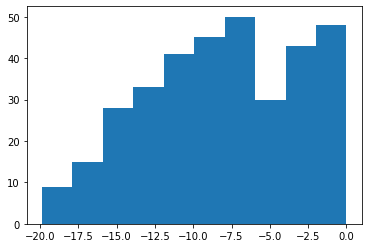

In [15]:
plt.hist(distance_from_surface,bins=10)

(z - surface) / (-bottom - surface) = relative_depth
-8.61 - 1.07 / -16.88 - 1.07 = 0.54
-9.68 / -15.81 = 0.54


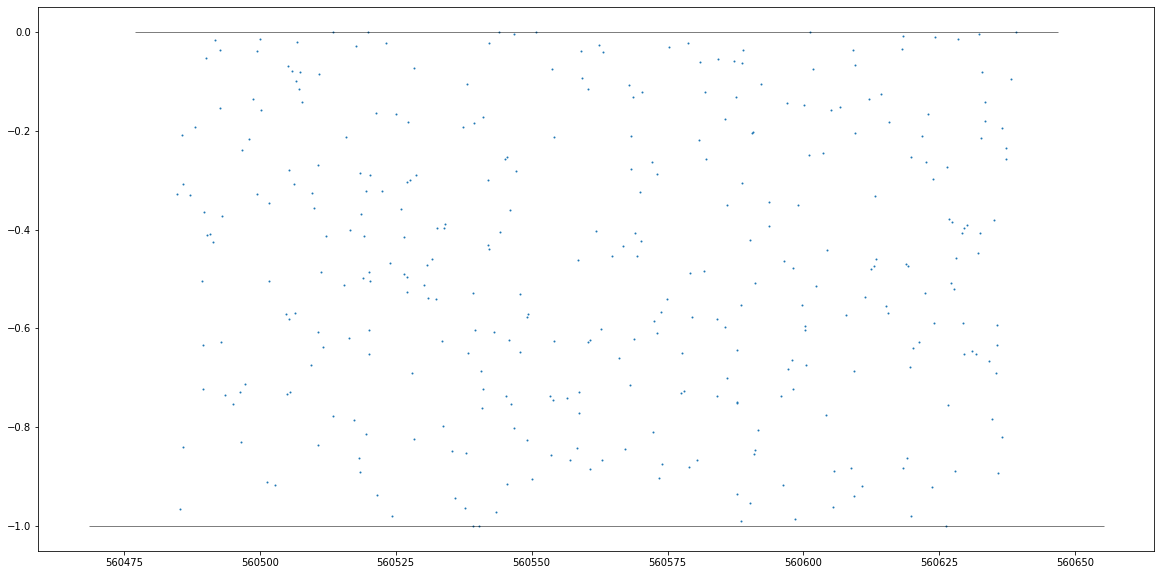

In [16]:
# rescale depth to relative from surface to bottom
x = tracks['x'][np.where(tracks['status'] > 0)]
inside = deepcopy(observational_polygone[-1]['InsidePolygon'].is_inside(x))
x = x[inside]
z = x[:,2]

bottom = tracks['water_depth']
bottom = bottom[np.where(tracks['status'] > 0)]
bottom = bottom[inside]

surface = tracks['tide']
surface = surface[np.where(tracks['status'] > 0)]
surface = surface[inside]

# scale vertical position linearly with 0 at surface and 1 at bottom
relative_depth = (z - surface)/(-bottom - surface)

# print an example of this equation with values for index ii
#(z - surface)/(-bottom - surface)

ii = 1
print('(z - surface) / (-bottom - surface) = relative_depth')
print(f'{round(z[ii],2)} - {round(surface[ii],2)} / -{round(bottom[ii],2)} - {round(surface[ii],2)} = {round(relative_depth[ii],2)}')
# simplify equation 
print(f'{round(z[ii] - surface[ii],2)} / -{round(bottom[ii] - surface[ii],2)} = {round(relative_depth[ii],2)}')


plt.figure(figsize=(20,10))
plt.scatter(x[:,0],-relative_depth,s=1)
plt.hlines(0,plt.xlim()[0],plt.xlim()[1],color='k',linewidth=0.5)
plt.hlines(-1,plt.xlim()[0],plt.xlim()[1],color='k',linewidth=0.5)

## where do they die?

In [3]:
# tracks
tracks = load_output_files.load_particle_track_vars(cases[0], var_list=['tide','water_depth'])

In [8]:
death = tracks['x'][:-1][np.array(np.array(np.diff(tracks['status'],axis=0) < 0)[:,:] * tracks['status'][1:,:] < 0)]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
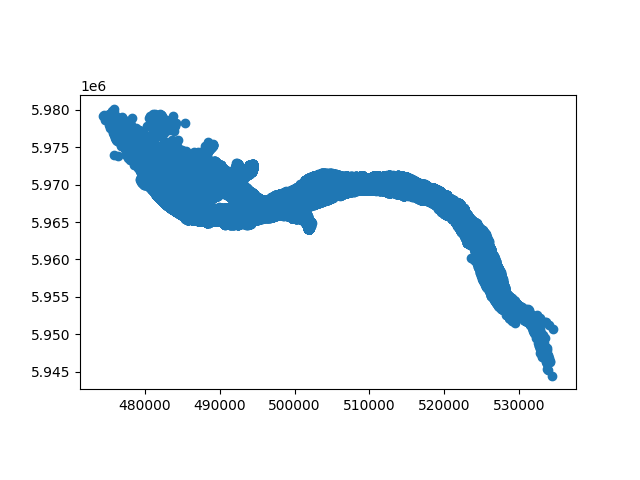

In [13]:
%matplotlib widget
fig,ax = plt.subplots(1,1)
plt.scatter(death[:,0], death[:,1])

# fix aspect ratio 
ax.set_aspect('equal', 'box')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
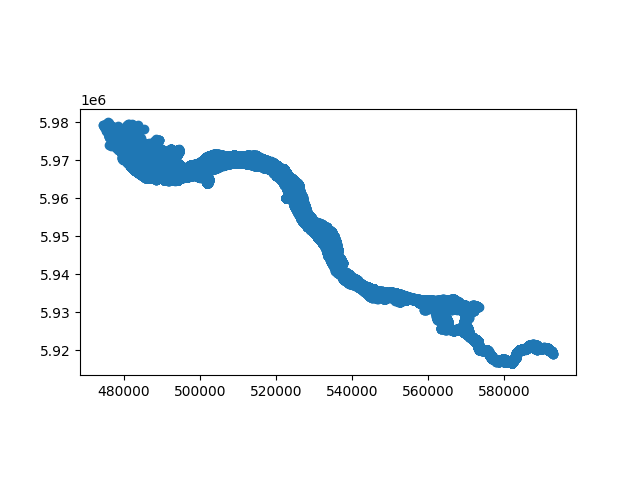

In [14]:
%matplotlib widget
fig,ax = plt.subplots(1,1)
plt.scatter(tracks['x'][-1,:,0], tracks['x'][-1,:,1])

# fix aspect ratio 
ax.set_aspect('equal', 'box')

## illumination field related stuff

In [6]:
%matplotlib widget

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
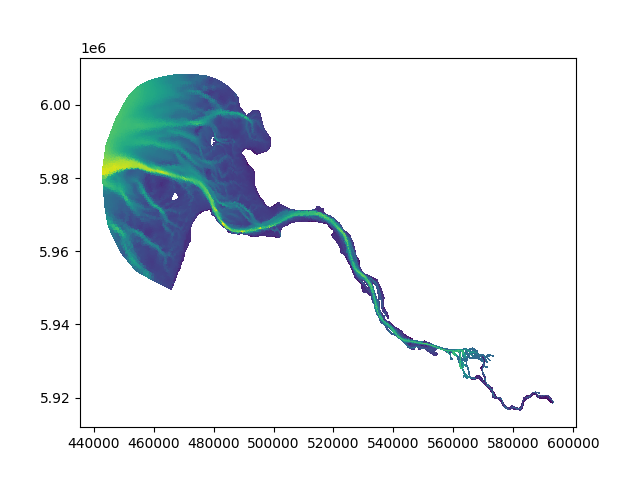

In [30]:
# plot grid to select x cut off
plt.tripcolor(grid['x'][:,0],grid['x'][:,1],grid['triangles'],grid['water_depth'],shading='flat')

In [35]:
x_cut_off = [5e5,5.65523e5]



In [10]:
path_to_case = '/scratch/local1/output/22_11_01_depth_losses_v15/22_11_01_depth_losses_v15_caseInfo.json'
tracks = load_output_files.load_track_data(path_to_case, var_list=['tide','water_depth','illumination'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
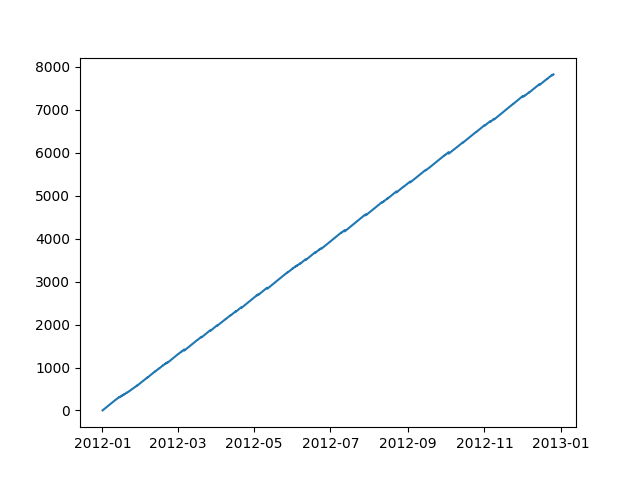

In [32]:
# plot count of active particles (status>0) over time

# from posix to datetime
t = tracks['time']
t = [datetime.fromtimestamp(tt) for tt in t]

n_active = np.empty_like(tracks['time'],dtype=int)

for ii in range(len(tracks['time'])):
    n_active[ii] = np.sum(tracks['status'][ii,:] > 0)

fig,ax = plt.subplots(1,1)
ax.plot(t,n_active)


culling doesn't work anymore. anyway:

In [56]:
# take particles closest to mid of the year
mid_year = datetime(2012,7,1)
mid_year = mid_year.timestamp()

# find index of particle closest to mid year
idx = np.argmin(np.abs(tracks['time'] - mid_year))

# create two subsets on with particles in x_cut_off and one right of right cut-off
alive_particles = tracks['x'][idx,:][np.where(tracks['status'][idx,:] > 0)]

# > x_cut_off[0] and < x_cut_off[1]
idx_of_deep_particles = np.where((alive_particles[:,0] > x_cut_off[0]) * (alive_particles[:,0] < x_cut_off[1]))
# idx_of_deep_particles = np.where(alive_particles[idx_of_deep_particles,0] < x_cut_off[1])[0]
# > x_cut_off[1]
idx_of_shallow_particles = np.where(alive_particles[:,0] > x_cut_off[1])[0]

illumination_deep = tracks['illumination'][idx,:][np.where(tracks['status'][idx,:] > 0)][idx_of_deep_particles]
illumination_shallow = tracks['illumination'][idx,:][np.where(tracks['status'][idx,:] > 0)][idx_of_shallow_particles]

In [55]:
(alive_particles[:,0] > x_cut_off[0]) * (alive_particles[:,0] < x_cut_off[1])

array([False,  True,  True, ..., False, False, False])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
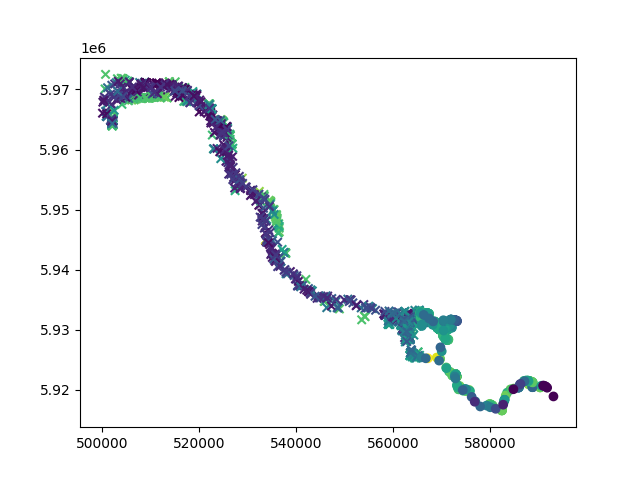

In [57]:
# make scatter of deep and shallow particles
fig,ax = plt.subplots(1,1)
ax.scatter(alive_particles[idx_of_deep_particles,0],alive_particles[idx_of_deep_particles,1],c=illumination_deep,marker='x')
ax.scatter(alive_particles[idx_of_shallow_particles,0],alive_particles[idx_of_shallow_particles,1],c=illumination_shallow,marker='o')


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f9a9f5b3910>,
  <matplotlib.collections.PolyCollection at 0x7f9a9f5b3cd0>]}

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
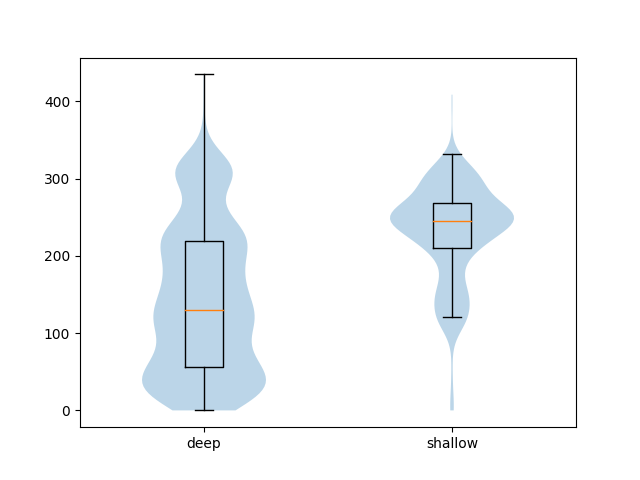

In [66]:
# box plot of illumination
fig,ax = plt.subplots(1,1)
ax.boxplot([illumination_deep,illumination_shallow],labels=['deep','shallow'],showfliers=False)
# add violin plot
ax.violinplot([illumination_deep,illumination_shallow],positions=[1,2],showmeans=False, showextrema=False,points=100)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
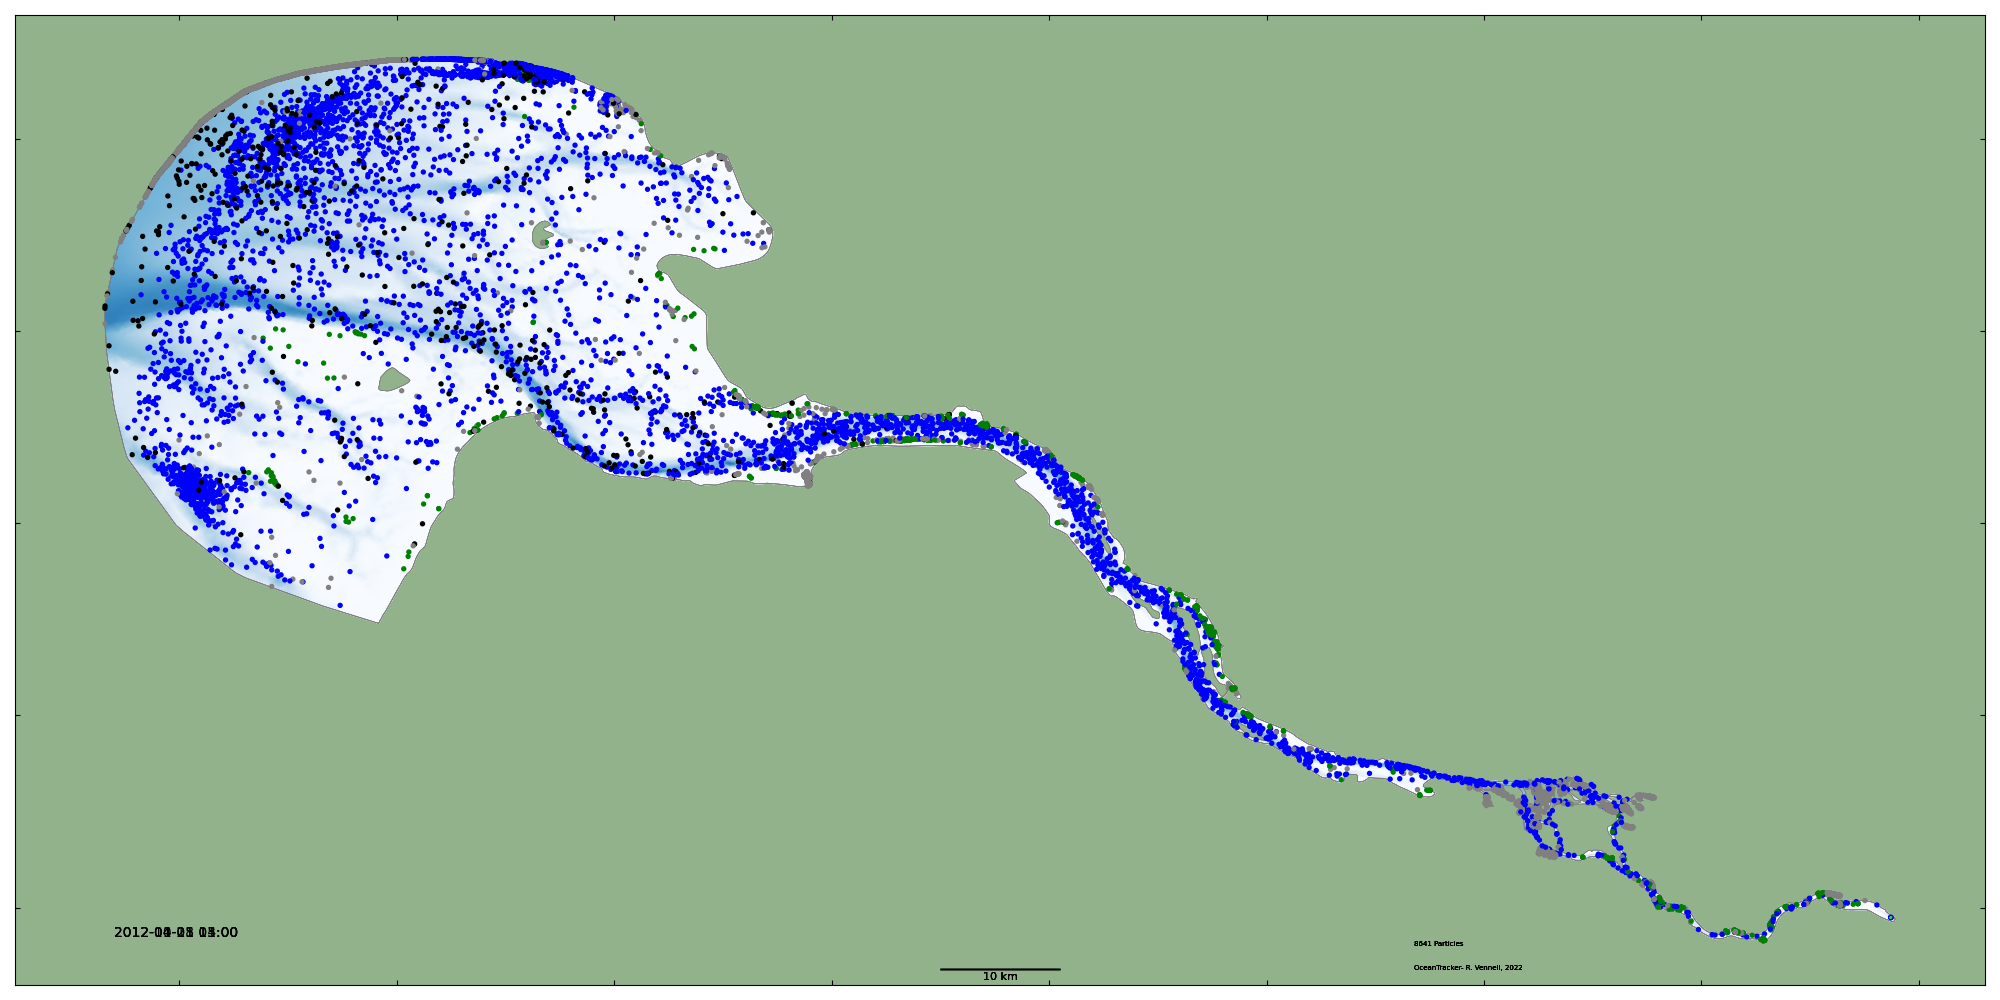

In [28]:
# animate tracks
from oceantracker.post_processing.plotting.plot_tracks import animate_particles

animate_particles(tracks, axis_lims=None, colour_using_data= None, show_grid=False, title=None, max_duration=None,
                      movie_file= None, fps=30, dpi=300, interval=100, size=8,
                      polygon_list_to_plot = None, min_status=0,
                      back_ground_depth=True, back_ground_color_map = None, credit=None, heading= None,
                      size_using_data= None,  part_color_map=None,
                      vmin=None, vmax=None,
                      release_group=None, show_dry_cells = False, show=True)

In [29]:
# close all
plt.close('all')